In [1]:
import os, sys
os.environ['R_HOME'] = sys.exec_prefix+"/lib/R/"

import cudf
import sys
import scanpy as sc
import scFates as scf
sys.path.append("../ConceptFates/")
sc.settings.verbosity=3
sc.set_figure_params(dpi=150)
scf.set_figure_pubready()
import load_gpu

In [2]:
import pandas as pd
data_path="../../ML4-5"

In [3]:
adata=load_gpu.read_mtx_gpu(f"{data_path}/matrix.mtx").T

Getting mtx
    loading to device
    transfering to host and converting to anndata


In [4]:
adata.obs_names=pd.read_csv(f"{data_path}/barcodes.tsv",header=None)[0].values
adata.var_names=pd.read_csv(f"{data_path}/features.tsv",header=None)[0].values

In [5]:
adata.obs["leiden"]=pd.read_table(f"{data_path}/leiden.tsv",header=None)[0].values.astype(str)

In [6]:
adata.obsm["X_umap"]=pd.read_csv(f"{data_path}/UMAP.csv",index_col=0).values
adata.obsm["X_pca"]=pd.read_csv(f"{data_path}/PCA.csv",index_col=0).values

In [7]:
adata.obs["batch"]=list(map(lambda n: n.split("_")[0], adata.obs_names))


In [8]:
adata.obs.batch=adata.obs.batch.astype("category")
adata.obs.leiden=adata.obs.leiden.astype("category")

In [9]:
cols=pd.read_csv("../leiden_colors.csv",index_col=0)

In [10]:
adata.obs.leiden.cat.categories

Index(['1', '12', '13', '14', '2', '3', '4', '5', '6', '7', '9'], dtype='object')

In [11]:
assignment=pd.Series({"14":"NCC","7":"ME",
 "5":"OR","1":"OF",
 "10":"EE","11":"FB",
 "4":"PS1","2":"PS2","9":"PO",
 "12":"PD","6":"ZL","8":"NSC",
 "3":"ON","13":"B"})

In [12]:
adata.obs.leiden= \
    adata.obs.leiden.cat.rename_categories(
        assignment[adata.obs.leiden.cat.categories].values
    )

In [13]:
adata.uns["leiden_colors"]=cols.loc[adata.obs.leiden.cat.categories]["0"].values

In [14]:
adata.obs.leiden.value_counts().index[:-1].values

['OF', 'ON', 'ME', 'PS1', 'PS2', 'ZL', 'PO', 'OR', 'B', 'PD']
Categories (11, object): ['OF', 'PD', 'B', 'NCC', ..., 'OR', 'ZL', 'ME', 'PO']

/home/lfaure/miniconda3/envs/3step_paper/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


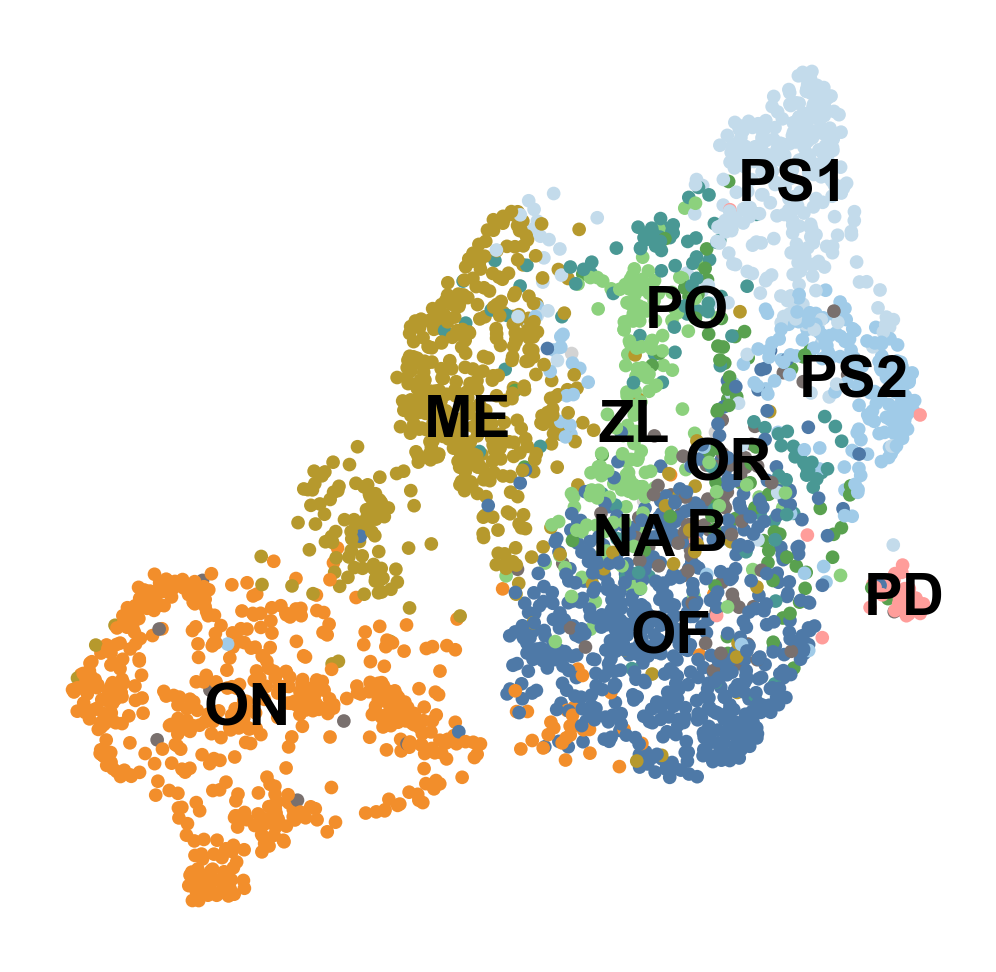

In [15]:
import matplotlib.pyplot as plt
sc.set_figure_params(frameon=False,dpi=150)
fig,ax=plt.subplots()
sc.pl.umap(adata,color="leiden",legend_loc="on data",title="",
           groups=adata.obs.leiden.value_counts().index[:-1].values,
          show=False,ax=ax)
plt.savefig("E11_umap.pdf",dpi=600)

In [16]:
import proportion_test

In [17]:
import warnings
warnings.filterwarnings("ignore")
prop_res = proportion_test.proportion_test(adata,"batch","leiden","ML4","ML5",
                      n_permutations=10000,n_jobs=10)

  0%|          | 20/10000 [00:01<08:03, 20.63it/s]/home/lfaure/miniconda3/envs/3step_paper/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/lfaure/miniconda3/envs/3step_paper/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/lfaure/miniconda3/envs/3step_paper/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|          | 40/10000 [00:01<03:37, 45.88it/s]/home/lfaure/miniconda3/envs/3step_paper/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
  2%|▏         | 160/10000 [00:01<00:41, 237.67it/s]/home/lfaure/miniconda3/envs/3st

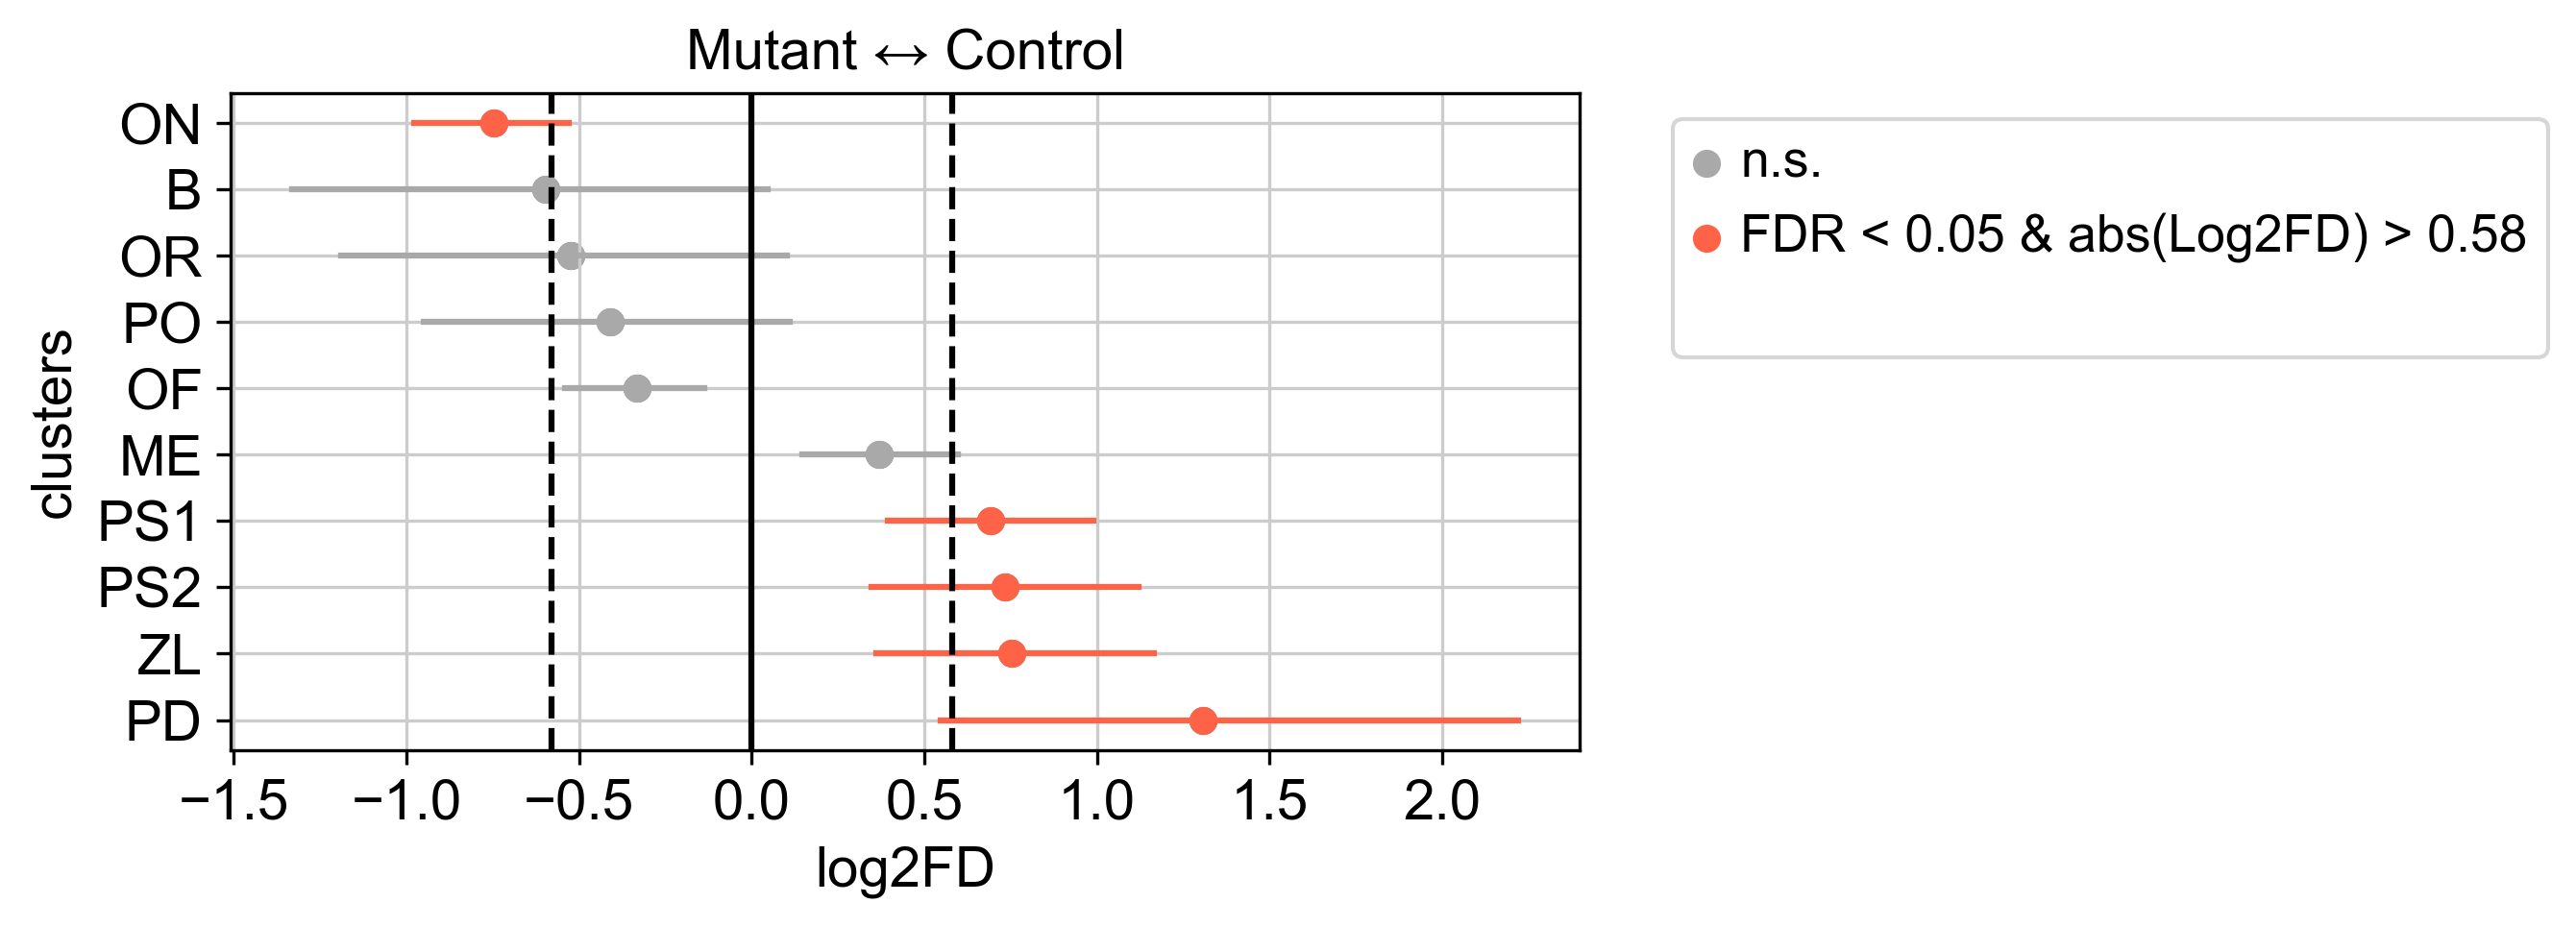

In [19]:
import imp
imp.reload(proportion_test)

import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(6,3))
proportion_test.plot_proportion_test(prop_res,ax=ax)
ax.set_title(r"Mutant ↔ Control")
ax.set_xlabel("log2FD")
plt.savefig("perm_test.pdf")

In [21]:
prop_res.to_csv("results/perm_test_res_ML4-5.csv")

In [22]:
adata.obs["log2FD"]=adata.obs["leiden"]

In [23]:
adata.obs["log2FD"]=adata.obs["log2FD"].astype(str).replace(prop_res.obs_log2FD.index,prop_res.obs_log2FD)

In [29]:
import matplotlib.colors as mcolors
con = "#5A7DBF"
mid = "white"
mut = "#D98C5F"
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [mut, mid, con])

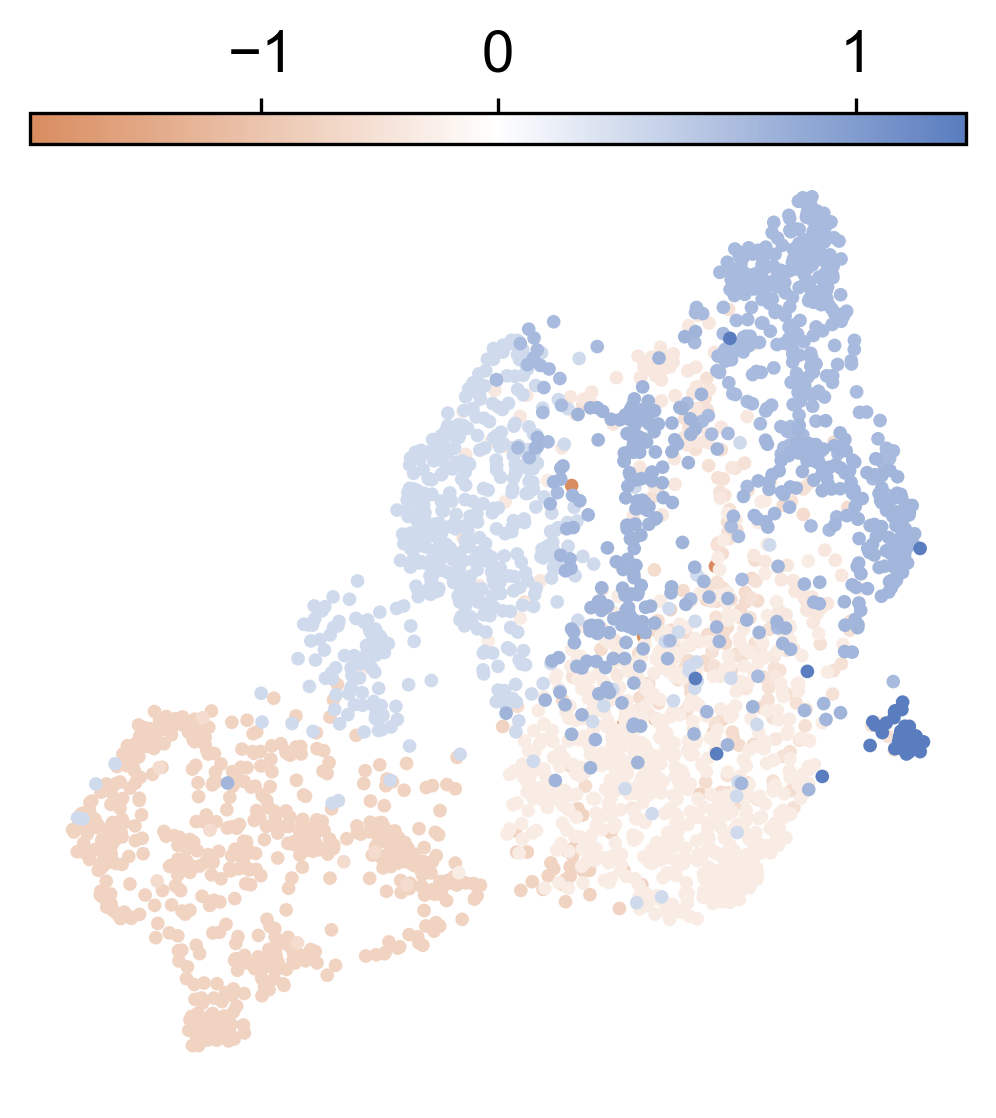

In [37]:
fig,ax=plt.subplots(figsize=(4,4.5))
sc.pl.umap(adata,color="log2FD",title="",show=False,ax=ax,
           cmap=cmap,vcenter=0,colorbar_loc="top")
plt.savefig("E11_umap_prop.pdf",dpi=600)

In [63]:
res=pd.DataFrame(0,index=adata.obs.batch.cat.categories,columns=adata.obs.leiden.cat.categories)
res=pd.concat(list(map(lambda b: (adata.obs.loc[adata.obs.batch==b,"leiden"].value_counts()/(adata.obs.batch==b).sum())*100,
         adata.obs.batch.cat.categories)),axis=1)
res.columns=adata.obs.batch.cat.categories

totals=pd.DataFrame(list(map(lambda b: (adata.obs.batch==b).sum(),res.columns)),
            columns=["total"],index=res.columns).T

res.index = res.index.astype(str)

res = pd.concat([res,pd.DataFrame(list(map(lambda b: (adata.obs.batch==b).sum(),res.columns)),
            columns=["total"],index=res.columns).T],axis=0)
res.loc["total"]=res.loc["total"].astype(int)

In [64]:
res.to_csv("results/prop_totals_ML4-5.csv")

In [65]:
res

,ML4,ML5
OF,25.527831,20.260374
PD,1.151631,2.847844
B,3.198976,2.115541
NCC,0.319898,0.081367
PS2,5.630198,9.357201
ON,25.655790,15.296989
PS1,9.021113,14.564687
OR,3.390915,2.359642
ZL,5.118362,8.624898
ME,16.122841,20.829943
